In [1]:
import platform
platform.python_version()

In [2]:
import os 

In [3]:
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\\bin")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\libnvvp")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\extras\CUPTI\lib64")
os.add_dll_directory("C:\Program Files\\NVIDIA GPU Computing Toolkit\CUDA\\v10.1\include")
os.add_dll_directory("C:\Program Files\\NVIDIA Corporation\\Nsight Compute 2019.4.0")

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import imageio
import glob
import time
from IPython import display
from tensorflow.keras.activations import relu

In [5]:
#import sys
#!{sys.executable} -m pip install tensorflow_datasets

In [6]:
print("Num GPUs Available" ,(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
batch_size=128
image_size=(64, 64)
noise_dim = 300

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "F:\messy code\Anime Face Generation\\faces",
  image_size= image_size,
  label_mode=None,
  batch_size= batch_size)

Found 63564 files belonging to 1 classes.


In [8]:
print(train_ds)

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>


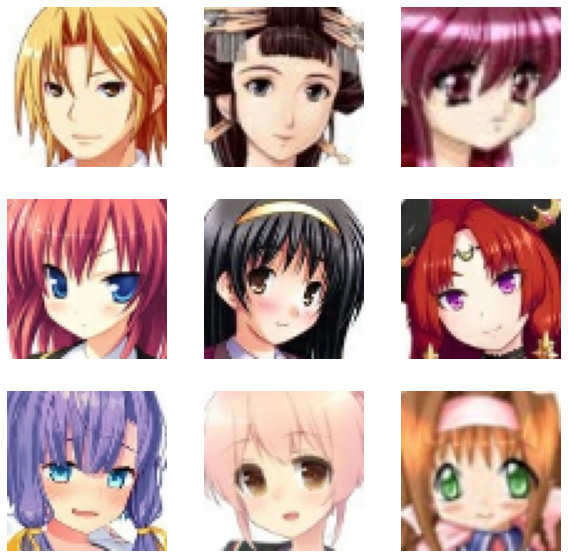

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias = False, input_shape =(noise_dim,),kernel_initializer = 'glorot_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8,8,256)))
    
    assert model.output_shape == (None,8,8,256)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5), strides=(2,2), padding='same',use_bias = False,data_format='channels_last',kernel_initializer = 'glorot_uniform'))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False,data_format='channels_last',kernel_initializer = 'glorot_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides = (2,2),padding = 'same',use_bias = False,data_format='channels_last',activation = 'tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[126.92602  127.061066 127.005615]
  [127.08721  127.198784 127.04711 ]
  [126.874596 126.88106  127.01637 ]
  ...
  [126.99797  127.11484  126.86597 ]
  [127.26804  126.72842  127.01184 ]
  [126.99514  127.52968  127.30166 ]]

 [[127.03643  127.07381  126.99029 ]
  [127.42962  127.50685  126.7922  ]
  [127.248215 126.74808  126.63081 ]
  ...
  [128.66786  126.66035  126.01544 ]
  [127.38749  127.17289  127.34361 ]
  [127.248116 126.53743  127.60998 ]]

 [[127.18136  127.18136  126.964325]
  [127.373085 126.90441  127.23697 ]
  [126.853516 127.50891  127.42187 ]
  ...
  [127.42422  126.84798  127.00621 ]
  [128.13803  127.135765 126.96503 ]
  [126.6743   127.50558  127.2332  ]]

 ...

 [[126.93057  126.64322  127.35747 ]
  [127.12956  128.54678  127.05429 ]
  [127.65251  126.64728  127.21603 ]
  ...
  [126.27166  129.27182  124.70353 ]
  [129.59822  126.46658  126.187294]
  [127.452644 126.580956 125.14448 ]]

 [[127.027794 126.8331   126.88778 ]
  [126.69245  126.31535  1

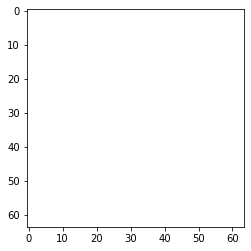

In [11]:
generator = generator_model()

noise = tf.random.uniform([1,noise_dim])

generated_image = generator(noise, training = False)*127 + 127
print(generated_image[0, :, :, :])
plt.imshow(generated_image[0, :, :, :])

In [12]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(
        64,
        (5,5),
        strides = (2,2),
        input_shape = (64,64,3),
        data_format='channels_last',
        activation ='relu'))
    model.add(layers.Conv2D(128,
                           (5,5),
                           strides = (2,2),
                           data_format='channels_last',
                           activation = 'relu'))
    model.add(layers.Conv2D(128,
                           (5,5),
                           strides = (2,2),
                           data_format='channels_last',
                           activation = 'relu'))
    model.add(layers.Conv2D(128,
                           (5,5),
                           strides = (2,2),
                           data_format='channels_last',
                           activation = 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, ))
              
    return model

In [13]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)
discriminator.summary()

tf.Tensor([[-18.116129]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       204928    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         409728    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,029,377
Trainable params: 1,029,377
Non-trainable

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [15]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real) , real)
    fake_loss = cross_entropy(tf.zeros_like(fake) , fake)
    total = real_loss + fake_loss
    return total

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
epochs = 50
num_examples_to_generate = batch_size

seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(seed)

tf.Tensor(
[[ 0.03006184  0.4908787  -0.25452128 ... -0.01992113  0.559516
  -1.1200248 ]
 [-0.1356546  -0.03485971  0.2291633  ... -1.6531639  -1.0886635
  -1.0032164 ]
 [ 0.7007042  -0.21031901  0.7704538  ... -1.3163635  -1.1765597
   0.06936372]
 ...
 [ 1.4465162   0.06786892 -0.13510036 ...  0.18619627 -0.9229553
  -0.81880647]
 [ 2.1804702   0.51740855  0.884438   ...  0.7786334   1.1782044
   0.04565565]
 [ 0.6576909  -0.4239509   0.17390306 ...  0.23804015  0.3386979
  -0.7440176 ]], shape=(128, 300), dtype=float32)


In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)*127+127

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_generator =  gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        

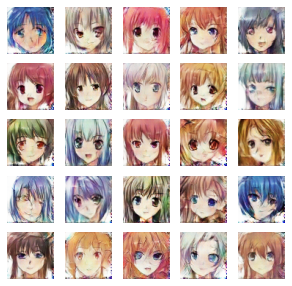

<tf.Tensor: shape=(128, 64, 64, 3), dtype=float32, numpy=
array([[[[222.75421  , 222.06049  , 227.70338  ],
         [234.61649  , 241.34988  , 242.04224  ],
         [241.87106  , 244.23895  , 246.38774  ],
         ...,
         [ 38.80957  ,  47.19124  ,  57.509216 ],
         [ 23.351784 ,  24.38359  ,  26.339981 ],
         [ 31.517532 ,  39.33378  ,  47.227196 ]],

        [[237.32172  , 239.40833  , 242.89313  ],
         [241.04971  , 244.8872   , 246.90567  ],
         [238.77888  , 247.4396   , 248.21637  ],
         ...,
         [107.018585 ,  94.7418   ,  82.03616  ],
         [167.43803  , 140.07751  , 161.09695  ],
         [174.06442  , 154.03122  , 142.91089  ]],

        [[239.84149  , 240.3645   , 242.95435  ],
         [239.22379  , 246.89888  , 247.96191  ],
         [239.70175  , 246.35498  , 247.52054  ],
         ...,
         [ 58.090584 ,  39.886284 ,  51.752037 ],
         [208.70459  , 183.36398  , 198.1213   ],
         [ 93.386604 ,  44.539566 ,  73.97551 

In [48]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)*127 + 127
    fig = plt.figure(figsize=(5,5))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, :].numpy().astype("uint8"))
        
    plt.savefig('epoch saves\image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return predictions
generate_and_save_images(generator, 10002, seed)

In [34]:
def train(dataset , epochs):
    for epoch in range(epochs):
        start = time.time()
        print("epoch {} starting".format(epoch))
        batch = 1
        for image_batch in train_ds:
            if batch%10 == 0 :
                print("batch counter : {} ".format(batch))
            batch += 1
            train_step(image_batch)
        
        #display.clear_output(wait = True)
        generate_and_save_images(generator,epoch + 1,seed)
        if(epoch+1 ) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                           epochs,
                           seed)

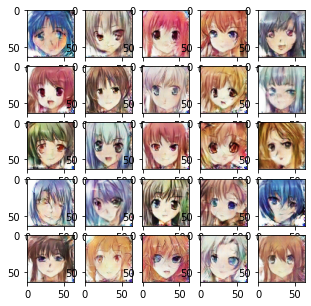

In [38]:
train(train_ds, epochs)

<ipython-input-21-bb1aa5192906>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4, 4, i+1)


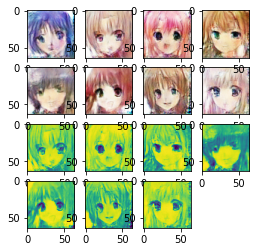

tf.Tensor(
[[ -4.851156  ]
 [  4.8340187 ]
 [ -9.8378725 ]
 [ -3.6326723 ]
 [ -4.3768973 ]
 [ -7.592263  ]
 [ -4.614408  ]
 [ -7.485867  ]
 [ -6.836295  ]
 [ -6.1545167 ]
 [ -7.230537  ]
 [  3.0383868 ]
 [ -1.0751255 ]
 [ -3.217015  ]
 [ -4.927274  ]
 [ -7.024866  ]
 [ -1.5682496 ]
 [ -4.219685  ]
 [ -6.051637  ]
 [ -6.341853  ]
 [ -7.54479   ]
 [ -7.4205685 ]
 [ -5.144444  ]
 [ -6.3538537 ]
 [ -2.3107479 ]
 [ -6.591768  ]
 [ -3.7925627 ]
 [ -3.6745336 ]
 [ -2.792169  ]
 [ -0.6450588 ]
 [ -4.707336  ]
 [ -9.430028  ]
 [ -6.831385  ]
 [ -7.339689  ]
 [ -3.6864061 ]
 [ -7.4750853 ]
 [ -2.3826416 ]
 [ -6.510654  ]
 [ -0.7143401 ]
 [ -4.706976  ]
 [ -2.2768426 ]
 [ -5.019363  ]
 [ -5.054708  ]
 [ -5.8200927 ]
 [ -5.384725  ]
 [ -6.412444  ]
 [ -2.8126848 ]
 [ -4.2261295 ]
 [ -4.689054  ]
 [  1.0378298 ]
 [ -4.247781  ]
 [ -4.517795  ]
 [ -3.8487892 ]
 [ -6.187601  ]
 [  1.4302717 ]
 [ -4.1411033 ]
 [ -3.922323  ]
 [ -5.9353137 ]
 [ -6.3232756 ]
 [ -9.314283  ]
 [ -4.3720274 ]
 [ -4.7188764

In [24]:
predictions = generate_and_save_images(generator, 10000000, seed)
print(discriminator(predictions, training = False))
print((train_ds.take(1)))


<ipython-input-21-bb1aa5192906>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(4, 4, i+1)


<Figure size 720x720 with 0 Axes>

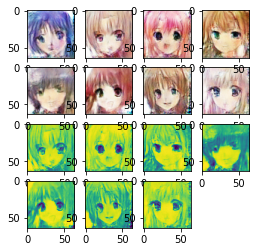

InvalidArgumentError: Index out of range using input dim 3; input has only 3 dims [Op:StridedSlice] name: strided_slice/

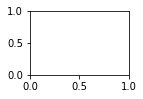

In [30]:
plt.figure(figsize=(10, 10))
for images in generate_and_save_images(generator, 9999999, seed):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i,:,:,:].numpy().astype("uint8"))

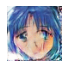

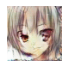

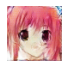

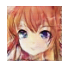

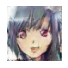

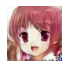

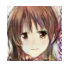

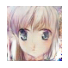

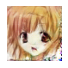

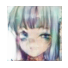

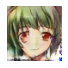

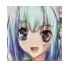

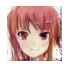

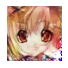

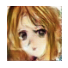

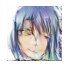

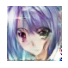

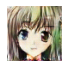

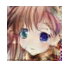

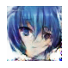

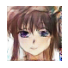

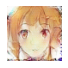

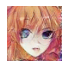

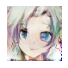

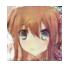

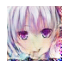

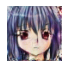

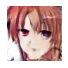

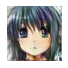

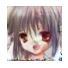

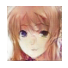

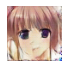

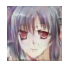

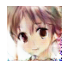

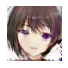

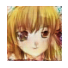

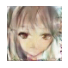

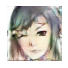

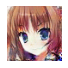

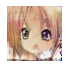

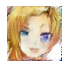

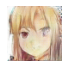

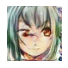

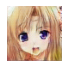

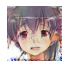

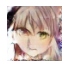

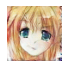

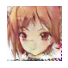

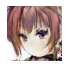

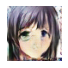

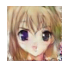

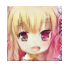

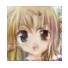

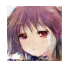

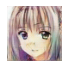

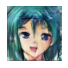

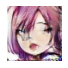

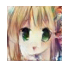

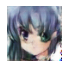

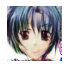

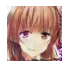

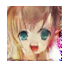

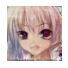

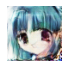

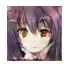

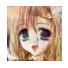

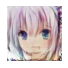

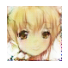

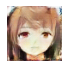

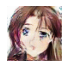

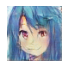

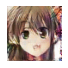

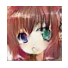

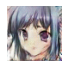

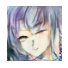

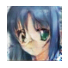

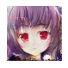

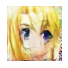

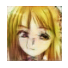

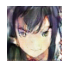

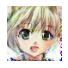

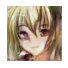

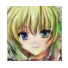

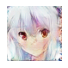

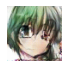

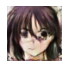

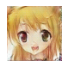

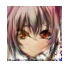

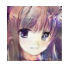

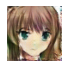

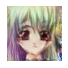

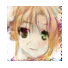

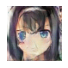

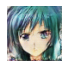

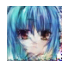

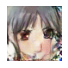

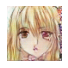

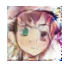

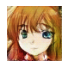

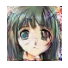

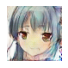

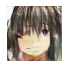

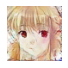

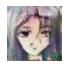

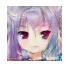

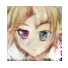

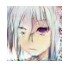

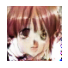

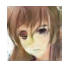

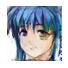

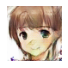

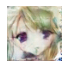

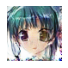

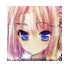

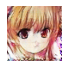

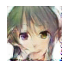

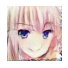

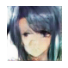

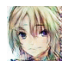

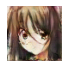

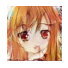

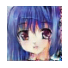

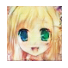

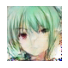

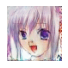

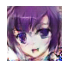

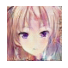

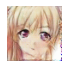

In [49]:
predictions = generator(seed, training=False)*127 + 127
num = 0
for i in range(batch_size):
    fig = plt.figure(figsize=(1,1))
    plt.subplot(1, 1, 1)
    plt.imshow(predictions[i , : , : , :].numpy().astype("uint8"))
    plt.axis('off')
    plt.savefig("first generation\{}.png".format(num))
    plt.show()
    num += 1

In [50]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints\\ckpt-16'